In [235]:
import numpy as np
import qgrid
import pandas as pd
import matplotlib.pyplot as plt

In [278]:
grade_propotion_list = np.array([
    4, 11, 23, 40, 60, 77,89,96,100
])

subject_default_mean = 100
subject_default_std = 20

elective_dict = {
    "언어와 매체" : {
        "s_num" : 5000, "o_c_mean" : 53, "o_c_std" : 12,  "o_e_mean" : 15, "o_e_std" : 5
    }, "화법과 작문" : {
        "s_num" : 5000, "o_c_mean" : 50, "o_c_std" : 12,  "o_e_mean" : 15, "o_e_std" : 5
    }
}

c_points_ratio = 0.74 #공통과목 비중
c_points = c_points_ratio * 100

elective_array = np.ndarray(0)
c_score_array = np.ndarray(0)
e_score_array = np.ndarray(0)

for subject, s_data in elective_dict.items():
    elective_array = np.concatenate((elective_array, np.full(s_data["s_num"],  fill_value = subject)), axis = 0)
    c_score_array = np.concatenate((c_score_array, np.random.normal(s_data["o_c_mean"],s_data["o_c_std"],
                                                                     (s_data["s_num"]))), axis = 0)
    e_score_array = np.concatenate((e_score_array, np.random.normal(s_data["o_e_mean"],s_data["o_e_std"],
                                                                     (s_data["s_num"]))), axis = 0)

data = {
    "elective" : elective_array,
    "o_c_score" : c_score_array,
    "o_e_score" : e_score_array
}

columns = ['elective', "o_c_score", "o_e_score"]
df = pd.DataFrame(data,  columns=columns)

df["o_c_score"] = df["o_c_score"].clip(upper = c_points, lower=0)


df["o_e_score"] = df["o_e_score"].clip(upper = 100 - c_points, lower=0)

df["o_c_score"] = df["o_c_score"].round()
df["o_e_score"] = df["o_e_score"].round()


# 불가능한 점수 ( 1점 또는 공통과목 74점 만점인데 73점 )는 그냥 빼기 1 해버렸다.,
# 어차피 평균과 표준편차의 상대적인 크기는 유지될 것이므로..
df["o_c_score"] = np.where((df["o_c_score"] == c_points - 1) | (df["o_c_score"] == 1)
                           , df["o_c_score"] - 1, df["o_c_score"])
df["o_e_score"] = np.where((df["o_e_score"] == 100 - c_points - 1) | (df["o_e_score"] == 1)
                           , df["o_e_score"] - 1, df["o_e_score"])



df["o_f_score"] = df["o_c_score"] + df["o_e_score"] # 공통과목 + 선택과목

df.groupby("elective").describe()

o_c_score                                                    \
             count     mean        std   min   25%   50%   75%   max   
elective                                                               
언어와 매체      5000.0  52.6168  11.457391  12.0  45.0  53.0  61.0  74.0   
화법과 작문      5000.0  49.9452  11.694988   2.0  42.0  50.0  58.0  74.0   

         o_e_score           ...             o_f_score                      \
             count     mean  ...   75%   max     count     mean        std   
elective                     ...                                             
언어와 매체      5000.0  15.0028  ...  18.0  26.0    5000.0  67.6196  12.384263   
화법과 작문      5000.0  14.9450  ...  18.0  26.0    5000.0  64.8902  12.610787   

                                         
           min   25%   50%   75%    max  
elective                                 
언어와 매체    23.0  59.0  68.0  76.0  100.0  
화법과 작문    17.0  56.0  65.0  74.0  100.0  

[2 rows x 24 columns]

In [230]:
df["group_o_c_mean"] = df["o_c_score"].groupby(df["elective"]).mean()[df["elective"]].values #선택과목 집단의 공통과목 원점수 평균
df["group_o_c_std"] = df["o_c_score"].groupby(df["elective"]).std()[df["elective"]].values #선택과목 집단의 공통과목 원점수 표준편차
df["group_o_e_mean"] = df["o_e_score"].groupby(df["elective"]).mean()[df["elective"]].values #선택과목 집단의 선택과목 원점수 평균
df["group_o_e_std"] = df["o_e_score"].groupby(df["elective"]).std()[df["elective"]].values #선택과목 집단의 선택과목 원점수 표준편차

def get_adjust_o_elective_score(o_e_score, group_o_c_mean, group_o_c_std, group_o_e_mean, group_o_e_std): # 선택과목 조정 원점수 산출

    return (o_e_score - group_o_e_mean) / group_o_e_std * group_o_c_std + group_o_c_mean

In [231]:
df["ao_e_score"] = get_adjust_o_elective_score(df['o_e_score'],
                                               df["group_o_c_mean"], 
                                               df["group_o_c_std"], 
                                               df["group_o_e_mean"], 
                                               df["group_o_e_std"]) # 선택과목 조정 원점수

all_o_c_mean = df["o_c_score"].mean() #모든 수험생 집단의 공통과목 원점수 평균
all_o_c_std = df["o_c_score"].std() #모든 수험생 집단의 공통과목 원점수 표준편차
all_ao_e_mean = df["ao_e_score"].mean() #모든 수험생 집단의 선택과목 원점수 평균
all_ao_e_std = df["ao_e_score"].std() #모든 수험생 집단의 선택과목 원점수 표준편차
# 두 평균과 표준편차는 사실 같다.

def get_adjust_z_score(o_c_score, ao_e_score ):
    return (o_c_score - all_o_c_mean) / all_o_c_std,  (ao_e_score - all_ao_e_mean) / all_ao_e_std

In [232]:
df["z_c_score"], df["z_e_score"] = get_adjust_z_score(df["o_c_score"], df["ao_e_score"]) #학생의 공통과목 표준화점수, 학생의 선택과목 표준화점수

def get_weighted_sum_z_score(z_c_score, z_e_score, c_points_ratio):
    return z_c_score * c_points_ratio + (1 - c_points_ratio) * z_e_score
df["weighted_sum_z_score"] = get_weighted_sum_z_score(df["z_c_score"], df["z_e_score"], c_points_ratio)

def get_final_z_score(weighted_sum_z_score, subject_default_mean, subject_default_std):
    return weighted_sum_z_score * subject_default_std + subject_default_mean
df["final_z_score"] = get_final_z_score(df["weighted_sum_z_score"], subject_default_mean, subject_default_std)

In [233]:
df.drop(["group_o_c_mean", "group_o_c_std", "group_o_e_mean", 
         "group_o_e_std", "z_c_score",
         "z_e_score", "weighted_sum_z_score"],errors='ignore', axis=1, inplace=True)

#등급 구하기 위한 백분위 
df['z_score_mock_percentile'] = df['final_z_score'].rank(method='min', ascending=False) / len(df) * 100

#실 백분위 : (자신보다 낮은 학생 수 + 동점자수 / 2) / 전체 학생 수 * 100
df["z_score_percentile"] = (df['final_z_score'].rank(method='min', ascending=True) - 1
           +df['final_z_score'].rank(method='max', ascending=True)) / 2 / len(df) * 100


conditions = [ df["z_score_mock_percentile"] <= x for x in grade_propotion_list ]
df["grade"] = np.select(conditions, np.arange(1,10), default="NA")


sorted_df  =df.sort_values(by=['final_z_score'], axis=0, ascending=False)
sorted_df[["elective", "o_c_score", "o_e_score", "o_f_score", "final_z_score", "z_score_percentile", "grade"]]

,elective,o_c_score,o_e_score,o_f_score,final_z_score,z_score_percentile,grade
1413,언어와 매체,74.0,26.0,100.0,141.004063,99.995,1
5528,화법과 작문,74.0,26.0,100.0,139.902602,99.970,1
4114,화법과 작문,74.0,26.0,100.0,139.902602,99.970,1
5651,화법과 작문,74.0,26.0,100.0,139.902602,99.970,1
4726,화법과 작문,74.0,26.0,100.0,139.902602,99.970,1
219,언어와 매체,74.0,24.0,98.0,138.926200,99.930,1
3875,언어와 매체,74.0,24.0,98.0,138.926200,99.930,1
2712,언어와 매체,74.0,24.0,98.0,138.926200,99.930,1
2349,언어와 매체,74.0,24.0,98.0,138.926200,99.930,1
3522,언어와 매체,72.0,26.0,98.0,138.486895,99.905,1


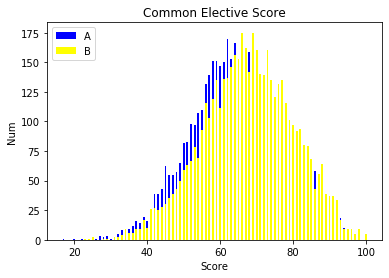

In [280]:
value_counts = df["o_f_score"].groupby(df["elective"]).value_counts()


bp_x = list(value_counts["화법과 작문"].index)
bp_y = value_counts["화법과 작문"].values
plt.bar(bp_x, bp_y, linewidth=0.1, linestyle="--",width=0.5,
         color="blue", label=r"A")

bp_x = list(value_counts["언어와 매체"].index)
bp_y = value_counts["언어와 매체"].values
plt.bar(bp_x, bp_y, linewidth=0.1, linestyle="--",width=0.5,
         color="yellow", label=r"B")

plt.xlabel("Score")
plt.ylabel("Num")
plt.title("Common Elective Score")

plt.legend(loc="upper left")
plt.show()
